In [59]:
import numpy as np
import pandas as pd
import brainiak.eventseg.event
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import pickle

cmap = plt.cm.Spectral
sns.reset_defaults()
%matplotlib inline

## Load data

In [60]:
video_model, recall_models = np.load('../data/models_t100_v50_r10.npy')

## Fit event segmentation model to video

In [3]:
def score_model(m, ev, r=0):
    mcorr = np.corrcoef(m)
    mcorr-=np.min(mcorr)
    mcorr/=np.max(mcorr)
    i1, i2 = np.where(np.round(ev.segments_[0])==1)
    w = np.zeros_like(ev.segments_[0])
    w[i1,i2] = 1
    w = np.dot(w, w.T).astype(bool)
    return (mcorr[w].mean()/mcorr[~w].mean())-r
    
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])
    

## Fit event segmentation model to video

In [49]:
ev = brainiak.eventseg.event.EventSegment(34)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

In [54]:
with open('../data/video_eventseg_model', 'wb') as f:
    pickle.dump(ev, f)
np.save('../data/video_events', video_events)

## Get video event times

In [5]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save('../data/video_event_times', video_event_times)

## Fit event segmentation model to recall

In [43]:
# ks = list(range(2, 30))
# maxk = []
# for i, sub in enumerate(recall_models):
#     mcorr = np.corrcoef(sub)
#     cs = []
#     for k in ks:
#         ev = brainiak.eventseg.event.EventSegment(k)
#         ev.fit(sub)
#         i1, i2 = np.where(np.round(ev.segments_[0])==1)
#         w = np.zeros_like(ev.segments_[0])
#         w[i1,i2] = 1
#         w = np.dot(w, w.T).astype(bool)
#         c = mcorr[w].mean()/mcorr[~w].mean() - k/50
#         cs.append(c)
#     m = ks[np.argmax(cs)]
#     maxk.append(m)
#     print(i, m)
maxk = np.array([8, 14, 11, 9, 14, 10, 17, 17, 10, 20, 19, 25, 27, 14, 10, 14, 23])

## Fit model to recall using best k

In [55]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk):
    ev = brainiak.eventseg.event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)
np.save('../data/recall_events', recall_events)
np.save('../data/recall_event_times', recall_event_times)

In [56]:
with open('../data/recall_eventseg_models', 'wb') as f:
    pickle.dump(recall_eventseg_models, f)

## Correlation between k and hand accuracy

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


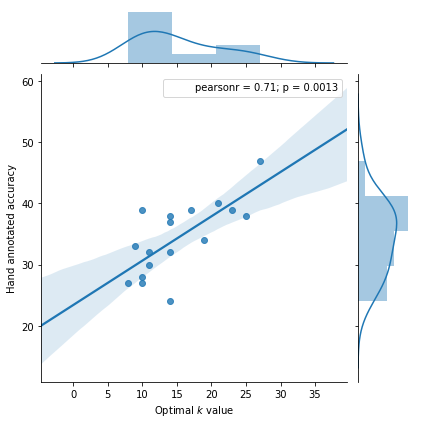

In [45]:
hand_acc = np.array([27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39])
df = pd.DataFrame(np.array([hand_acc, np.array(maxk_penalty)]).T, 
                  columns=['Hand annotated accuracy','Optimal $k$ value'])
sns.jointplot(data=df, y='Hand annotated accuracy', x='Optimal $k$ value', kind='reg')

## Create average recall model

In [61]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))
# avg_recall_events = np.array([a.reshape(100,) for a in avg_recall_events if a.shape==(100,)])
np.save('../data/avg_recall_events', avg_recall_events)

## Create 2D embeddings

In [1]:
np.random.seed(10)
embeddings = hyp.reduce(recall_events+[video_events]+[avg_recall_events], reduce='UMAP', ndims=2)

NameError: name 'np' is not defined

## Plot embeddings

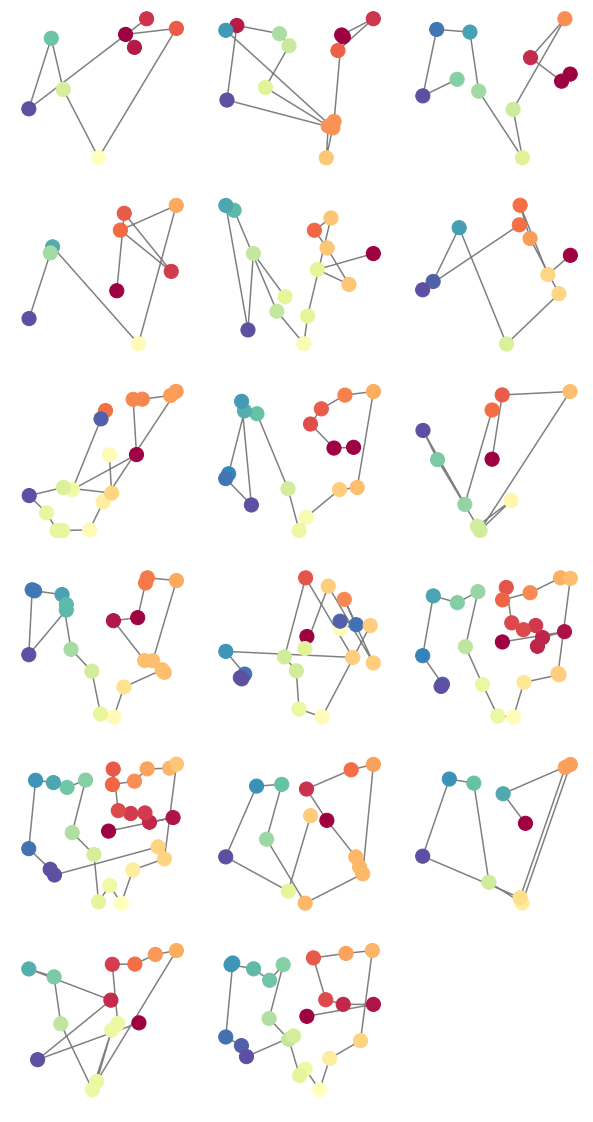

In [63]:
fig, axarr = plt.subplots(6, 3, figsize=(10, 20))
axarr = axarr.flatten()
for i, (m, e) in enumerate(zip(matches, embeddings[:-2])):
    axarr[i].scatter(e[:,0], e[:,1], c=m, cmap=cmap, s=200, zorder=2)
    axarr[i].plot(e[:,0], e[:,1], zorder=1, c='k', alpha=.5)
    axarr[i].axis('off')
axarr[i+1].axis('off')
plt.show()

## Save models

In [11]:
np.save('../data/events', [video_events, recall_events])
np.save('../data/embeddings', [embeddings[:-2], embeddings[-2], embeddings[:-1]])
np.save('../data/labels', matches)

## Load models

In [12]:
video_events, recall_events = np.load('../data/events.npy')
embeddings = np.load('../data/embeddings.npy')
embeddings = embeddings[0]+[embeddings[1]]+[embeddings[2][-1]]
matches = np.load('../data/labels.npy')
hinge_inds = [0, 2, 4, 8, 10, 13, 17, 19, 21, 23, 27, 31, 33]

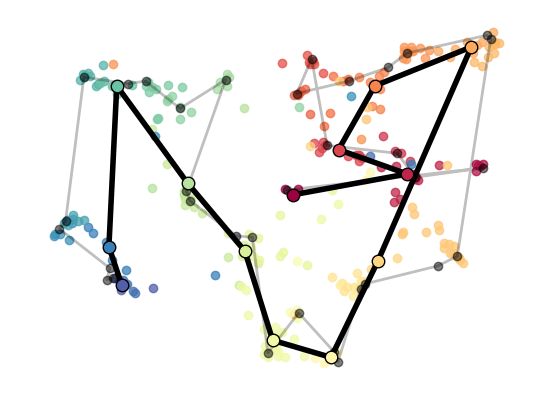

In [67]:
np.random.seed(1)
embeddings = hyp.reduce(recall_events+[video_events]+[avg_recall_events], reduce='UMAP', ndims=2)

sns.reset_defaults()
c = cmap(np.linspace(0, 1, 10))
sub_color = cmap(np.linspace(0, 1, 17))
subj_points = np.vstack(embeddings[:-2])
hinge_inds = [0, 2, 4, 8, 10, 13, 16, 19, 21, 23, 27, 31, 33]
# sns.kdeplot(subj_points, alpha=.25, cmap=plt.cm.gray_r, shade=True, shade_lowest=False)
for i, (sub, sub_match) in enumerate(zip(embeddings[:-2], matches)):
    for j, (p, m) in enumerate(zip(sub, sub_match)):
        plt.scatter(p[0], p[1], zorder=2, c=cmap(m/34), alpha=.75)
hinges = embeddings[-1][hinge_inds, :]
for i in range(len(hinges)-1):
    plt.plot([hinges[i, 0], hinges[i+1, 0]], [hinges[i, 1], hinges[i+1, 1]], c='k', linewidth=4)
for i in range(len(hinges)):
    plt.plot(hinges[i,0], hinges[i,1], 'o', c=cmap(hinge_inds[i]/34), zorder=4, markersize=7)
plt.plot(hinges[:,0], hinges[:,1], 'ko', zorder=3, markersize=9)
plt.plot(embeddings[-2][:,0], embeddings[-2][:,1], 'ko', alpha=.5)
plt.plot(embeddings[-2][:,0], embeddings[-2][:,1], 'k', linewidth=2, alpha=.25)
plt.axis('off')
plt.savefig('../figures/gist.pdf')
plt.show()

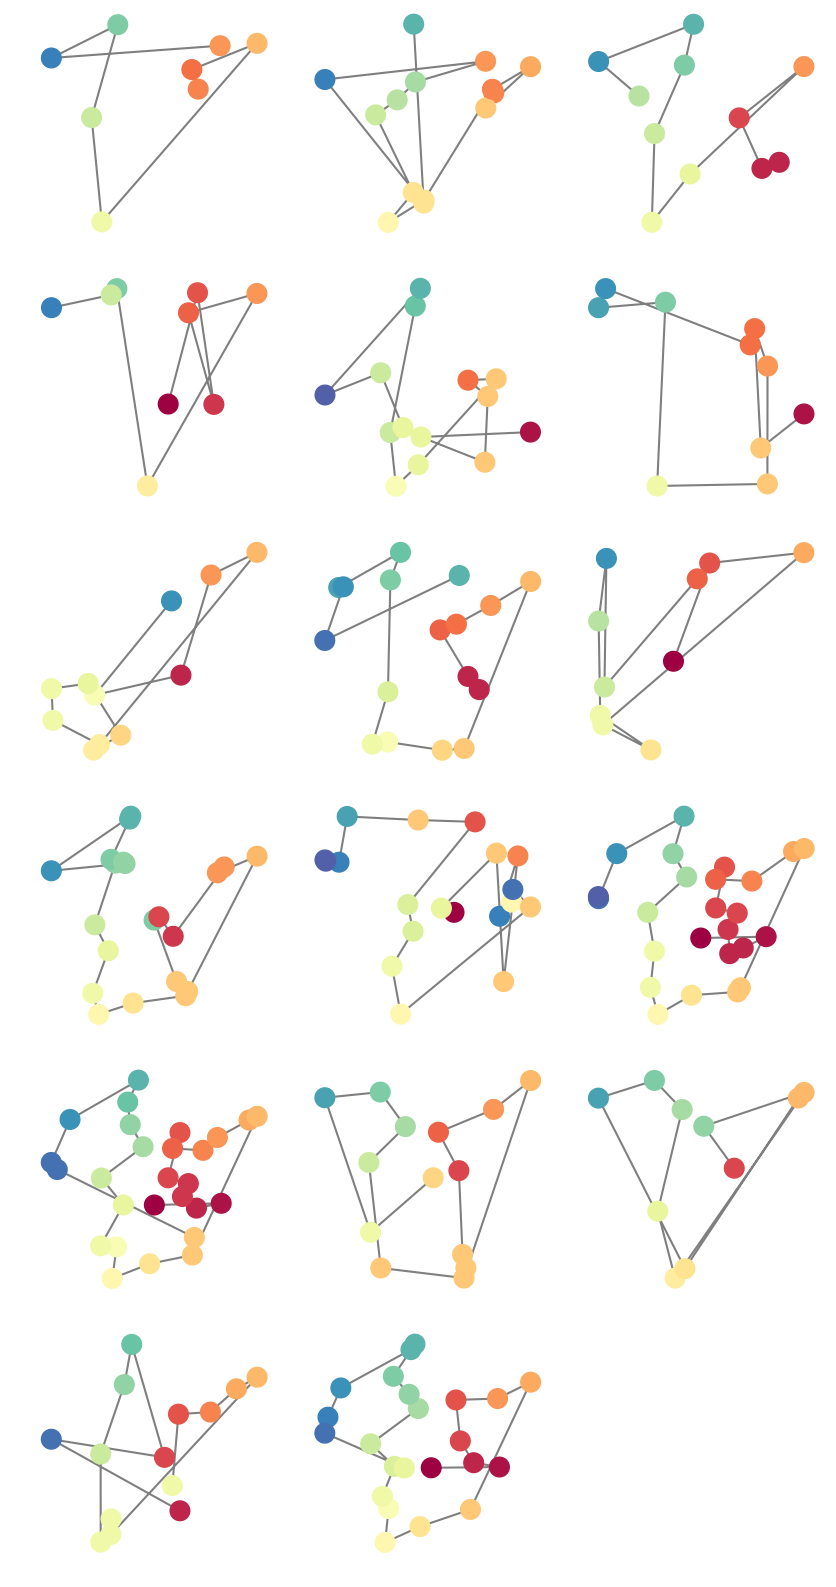

In [14]:
fig, axarr = plt.subplots(6, 3, figsize=(10, 20))
axarr = axarr.flatten()
for i, (m, e) in enumerate(zip(matches, embeddings[:-2])):
    axarr[i].scatter(e[:,0], e[:,1], c=cmap(m/34), cmap=cmap, s=200, zorder=2)
    axarr[i].plot(e[:,0], e[:,1], zorder=1, c='k', alpha=.5)
    axarr[i].axis('off')
axarr[i+1].axis('off')
plt.savefig('../figures/recall_traj_without_hinges.pdf')
plt.show()

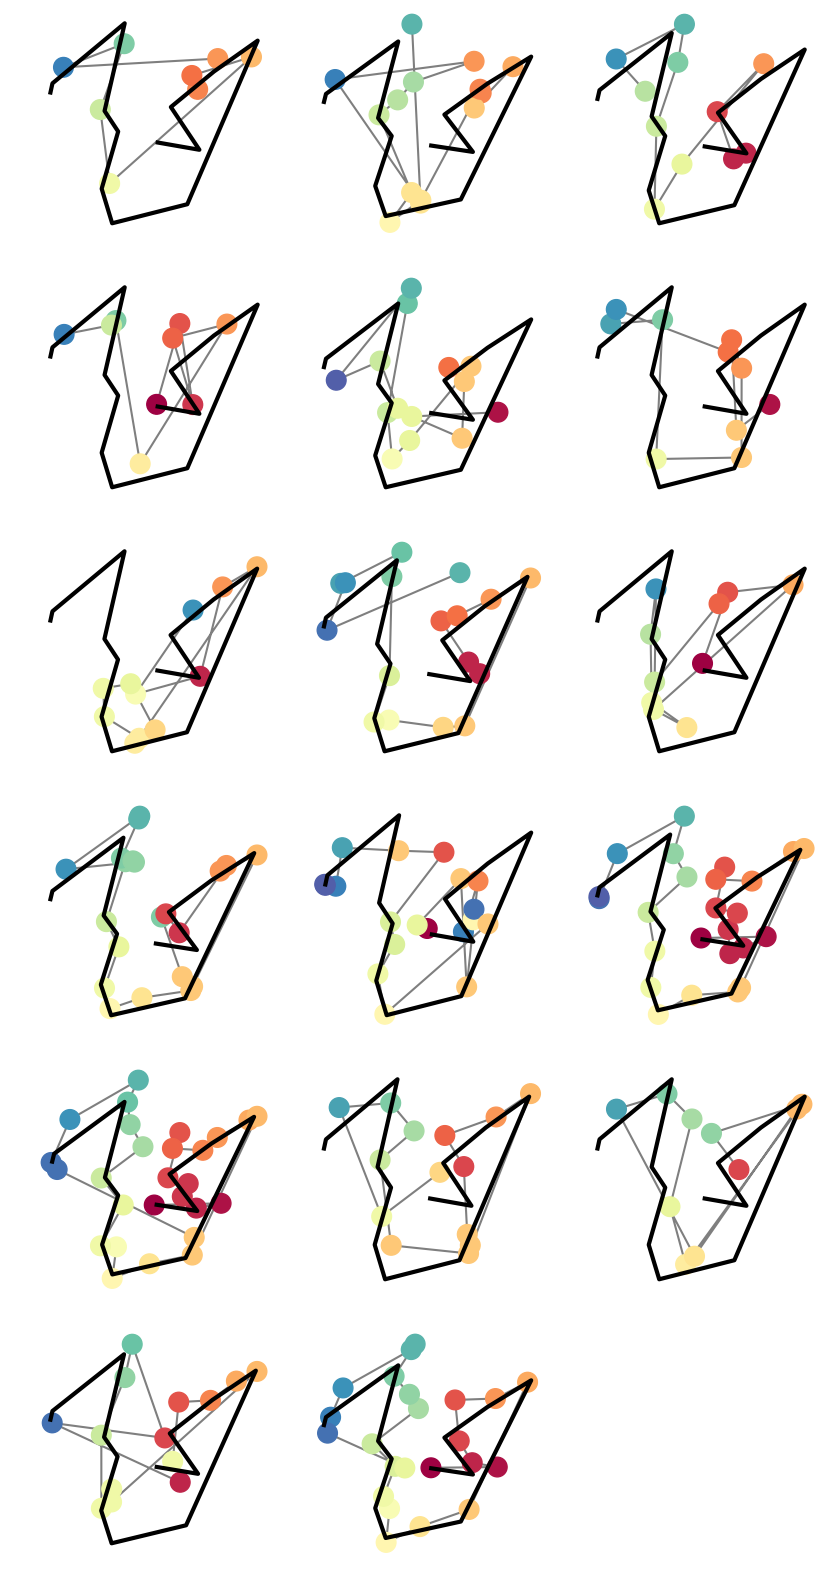

In [15]:
fig, axarr = plt.subplots(6, 3, figsize=(10, 20))
axarr = axarr.flatten()
for i, (m, e) in enumerate(zip(matches, embeddings[:-2])):
    axarr[i].scatter(e[:,0], e[:,1], c=cmap(m/34), cmap=cmap, s=200, zorder=2)
    axarr[i].plot(e[:,0], e[:,1], zorder=1, c='k', alpha=.5)
    axarr[i].plot(hinges[:,0], hinges[:,1], c='k', linewidth=3)
    axarr[i].axis('off')
axarr[i+1].axis('off')
plt.savefig('../figures/recall_traj_with_hinges.pdf')
plt.show()

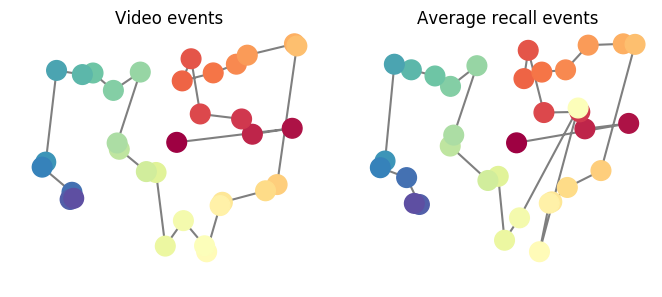

In [68]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].scatter(embeddings[-2][:, 0], embeddings[-2][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[0].plot(embeddings[-2][:, 0], embeddings[-2][:, 1], zorder=1, c='k', alpha=.5)
axarr[0].axis('off')
axarr[0].set_title('Video events')
axarr[1].scatter(embeddings[-1][:, 0], embeddings[-1][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[1].plot(embeddings[-1][:, 0], embeddings[-1][:, 1], zorder=1, c='k', alpha=.5)
axarr[1].axis('off')
axarr[1].set_title('Average recall events')
plt.savefig('../figures/avg_traj_without_hinges.pdf')

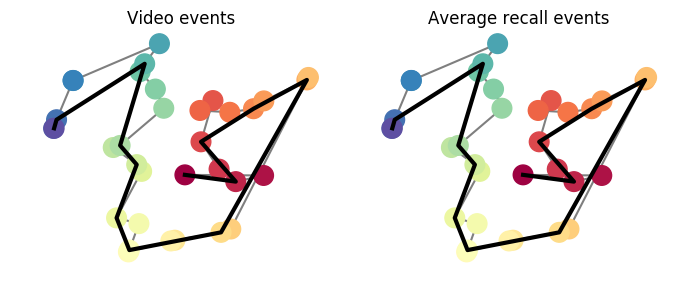

In [17]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].scatter(embeddings[-2][:, 0], embeddings[-2][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[0].plot(embeddings[-2][:, 0], embeddings[-2][:, 1], zorder=1, c='k', alpha=.5)
axarr[0].plot(hinges[:,0], hinges[:,1], c='k', linewidth=3)
axarr[0].axis('off')
axarr[0].set_title('Video events')
axarr[1].scatter(embeddings[-1][:, 0], embeddings[-1][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[1].plot(embeddings[-1][:, 0], embeddings[-1][:, 1], zorder=1, c='k', alpha=.5)
axarr[1].plot(hinges[:,0], hinges[:,1], c='k', linewidth=3)
axarr[1].axis('off')
axarr[1].set_title('Average recall events')
plt.savefig('../figures/avg_traj_with_hinges.pdf')


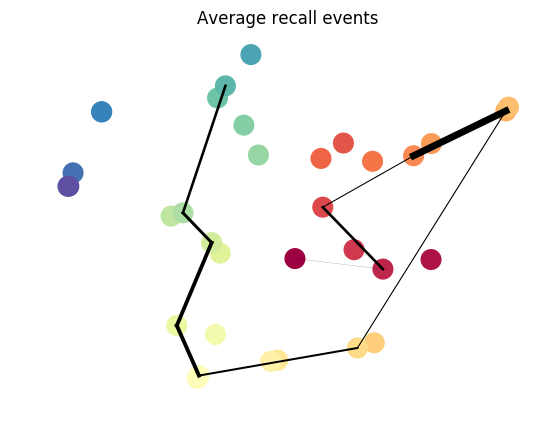

In [18]:
segment_importance = np.load('../data/segment_importance.npy')
si = segment_importance - min(segment_importance) +.1
si /= max(si)
line_segments = [(list(hinges[i, :]), list(hinges[i+1, :])) for i in range(len(hinges)-1)]
for l, s in zip(line_segments, si):
    plt.plot([l[0][0], l[1][0]], [l[0][1], l[1][1]], c='k', alpha=1, linewidth=s*5)
plt.scatter(embeddings[-1][:, 0], embeddings[-1][:, 1], c=range(34), cmap=plt.cm.Spectral, s=200, zorder=2)
# plt.plot(embeddings[-1][:, 0], embeddings[-1][:, 1], zorder=1, c='k', alpha=.5)
plt.axis('off')
plt.title('Average recall events')
plt.savefig('../figures/avg_traj_with_importance.pdf')

## Save out the top n topic inds for the hinges and line segments

In [19]:
topn = 5
seg_topics = [np.argsort(video_events[hinge_inds[i]:hinge_inds[i+1], :].mean(0))[::-1][:topn] for i in range(len(hinge_inds)-1)]
np.save('../data/seg_topic_inds', seg_topics)

In [20]:
topn = 5
hinge_topics = [np.argsort(video_events[hinge_inds[i], :])[::-1][:topn] for i in range(len(hinge_inds))]
np.save('../data/hinge_topic_inds', hinge_topics)

## Recal model transition probability matrix

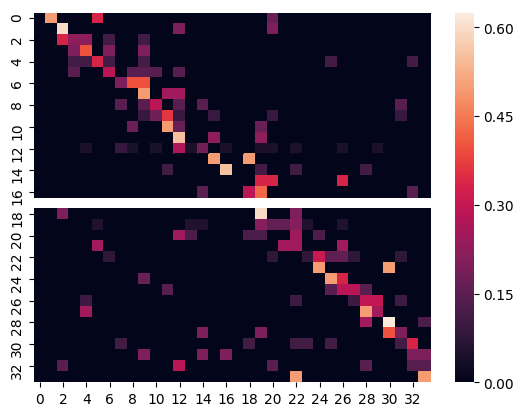

In [21]:
transition_mtx = np.zeros((34, 34))
for sub in matches:
    for i in range(len(sub)-1):
        transition_mtx[sub[i], sub[i+1]]+=1
norm_transition_mtx = np.array(list(map(lambda x: x/x.sum(), transition_mtx)))
sns.heatmap(norm_transition_mtx)
plt.show()

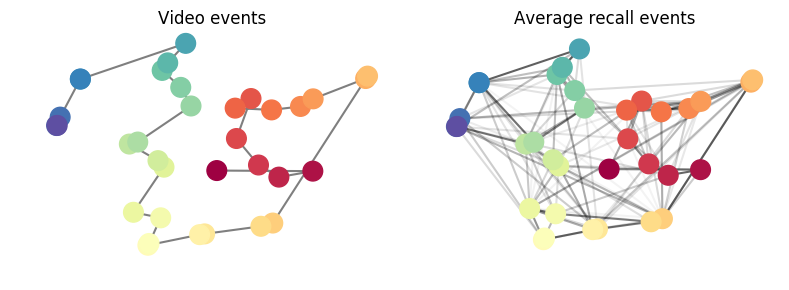

In [22]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].scatter(embeddings[-2][:, 0], embeddings[-2][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[0].plot(embeddings[-2][:, 0], embeddings[-2][:, 1], zorder=1, c='k', alpha=.5)
axarr[0].axis('off')
axarr[0].set_title('Video events')
for i in range(norm_transition_mtx.shape[0]):
    for j in range(norm_transition_mtx.shape[1]):
        if norm_transition_mtx[i, j]>0:
            axarr[1].plot([embeddings[-1][i][0], embeddings[-1][j, 0]], [embeddings[-1][i, 1], embeddings[-1][j, 1]], zorder=1, c='k', alpha=norm_transition_mtx[i, j])
axarr[1].scatter(embeddings[-1][:, 0], embeddings[-1][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
# axarr[1].plot(embeddings[-1][:, 0], embeddings[-1][:, 1], zorder=1, c='k', alpha=.5)
axarr[1].axis('off')
axarr[1].set_title('Average recall events')
plt.tight_layout()
plt.savefig('../figures/avg_traj_with_transitions.pdf')
plt.show()


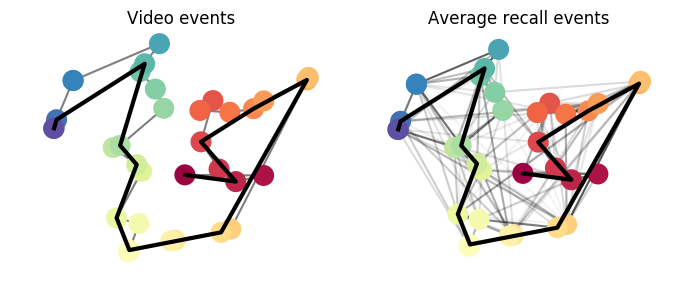

In [23]:
fig, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].scatter(embeddings[-2][:, 0], embeddings[-2][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[0].plot(embeddings[-2][:, 0], embeddings[-2][:, 1], zorder=1, c='k', alpha=.5)
axarr[0].plot(hinges[:,0], hinges[:,1], c='k', linewidth=3)
axarr[0].axis('off')
axarr[0].set_title('Video events')
for i in range(norm_transition_mtx.shape[0]):
    for j in range(norm_transition_mtx.shape[1]):
        if norm_transition_mtx[i, j]>0:
            axarr[1].plot([embeddings[-1][i][0], embeddings[-1][j, 0]], [embeddings[-1][i, 1], embeddings[-1][j, 1]], zorder=1, c='k', alpha=norm_transition_mtx[i, j])
axarr[1].scatter(embeddings[-1][:, 0], embeddings[-1][:, 1], c=range(34), cmap=cmap, s=200, zorder=2)
axarr[1].plot(hinges[:,0], hinges[:,1], c='k', linewidth=3)
axarr[1].axis('off')
axarr[1].set_title('Average recall events')
plt.savefig('../figures/avg_traj_with_transitions_hinges.pdf')
plt.show()